In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, max_error, mean_absolute_error, median_absolute_error
import sys  
sys.path.insert(0, '/content/drive/MyDrive/ML/Project 2/')
from preprocessing import *

# Data Variables

Two data files are available *Erlenbach_ion_concentration.csv* and *Erlenbach_probe_data10min.csv*. 

The first one (*Erlenbach_ion_concentration.csv*) lists the ion concentration measured from water samples. Missing values are indicated as NA. For Na, Mc, K and Ca, there are two measurements available (ion chromatrography and mass spectrometry). The ion chromatography is to be preferred, but mass spectrometry can be useful to fill some gaps.

- date is a datetime formatted as 2017-03-06T15:50:00Z in UTC+1
- Na, ..., SO4 are the ion concentrations measured through ion chromatography, in mg/l .(Good value)
- Na_MS, Mg_MS, K_MS, Ca_MS are the ion concentrations measured through ICP mass spectrometry, in ug/l
- comments explain some possible NA and anomalous values


The second one (*Erlenbach_probe_data10min.csv*) includes quasi-continuous data measured from in-situ probes. The data comes from 2 main probe types, here called WSL and SCAN. From sensors.

**common to both probe types**

- DATE_TIME_UTC+1: date time formatted as 2017-03-06 17:20:00 in UTC+1

**data from WSL probe**

- NS_mm/10min: precipitation, measured in mm/10min
- WT_dC: water temperature, measured in degrees Celsius
- LF_uS/cm: water electrical conductivity, measured in uS/cm
- Qu_mm/10min: flow, measured in mm/10min
- Comments_WSLdata: string with comments

**data from SCAN probe**

- Turbidity - Clean value [FTUeq] (Limit:0.00-150.00):
- NO3-Neq - Clean value [mg/l] (Limit:0.00-15.00):
- TOCeq - Clean value [mg/l] (Limit:0.00-20.00):
- DOCeq - Clean value [mg/l] (Limit:0.00-15.00):
- Dissolved Oxygen - Clean value [ppm] (Limit:0.00-25.00):
- Temperature DO - Clean value [°C] (Limit:0.00-50.00):
- Conductivity - Clean value [uS/cm] (Limit:0.10-600000.00):
- Temperature EC - Clean value [°C] (Limit:-20.00-130.00):
- pH - Clean value (Limit:0.00-14.00):
- ORP - Clean value [mV] (Limit:-2000.00-2000.00):
- Comments_SCANdata:

**other derived data**

- dQ/dt: variation of discharge over the time interval

Water - dilution in concentration
Ions from soil - in touch with soil - ions high concentration
Seasonal dynamics -> add a sinusoidal function.

Specifically for ion chromatography 
Calcium - strong with conductivity
Sulfate (SO4)
Nitrate - has low concentration

# Preprocessing

In [4]:
ion_concentration = read_ion_concentration_csv()
ion_concentration.head(100)

,date,Na,Mg,K,Ca,Cl,NO3,SO4,Na_MS,Mg_MS,K_MS,Ca_MS,comments_IC,comments_MS
0,2017-03-06 17:20:00,3.232,4.209,NaN,64.711,NaN,1.751,17.637,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-03-06 18:20:00,3.268,4.241,1.112,64.043,0.559,1.771,17.740,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-03-06 19:20:00,NaN,NaN,NaN,NaN,0.563,1.788,17.457,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-03-06 21:20:00,3.154,4.194,1.101,63.400,0.571,1.779,17.433,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-03-06 22:20:00,3.162,4.238,NaN,63.785,0.572,1.815,16.462,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2017-03-10 19:20:00,1.183,1.742,0.637,28.645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,2017-03-10 20:20:00,1.207,1.817,0.656,29.394,0.271,0.803,5.155,NaN,NaN,NaN,NaN,NaN,NaN
97,2017-03-10 20:50:00,NaN,1.681,0.585,26.387,0.282,0.789,5.122,NaN,NaN,NaN,NaN,NaN,NaN
98,2017-03-10 21:20:00,NaN,1.512,0.555,24.036,0.264,0.799,5.170,NaN,NaN,NaN,NaN,anomalous value,NaN


In [5]:
ion_concentration.shape

(19095, 14)

In [6]:
#does all the preprocessing on ion_concentration
prepare_ion_concentration_dataframe(ion_concentration)
ion_concentration = ion_concentration.drop('count_nan', axis=1)
ion_concentration.head(2)

,Na,Mg,K,Ca,Cl,NO3,SO4,Na_MS,Mg_MS,K_MS,Ca_MS,comments_IC,comments_MS
date,,,,,,,,,,,,,
2017-03-06 17:20:00,3.232,4.209,NaN,64.711,NaN,1.751,17.637,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-06 18:20:00,3.268,4.241,1.112,64.043,0.559,1.771,17.740,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
probe_data10min = read_probe_data10min_csv()
probe_data10min.head(2)

,date,precipitation,water_temperature,water_electrical_conductivity,flow,comments_WSLdata,turbidity,NO3-Neq,TOCeq,DOCeq,dissolved_oxygen,temperature_DO,conductivity,temperature_EC,pH,ORP,comments_SCANdata,dQ/dt
0,2016-08-30 00:00:00,0.0,14.2,259.0,0.007371,NaN,5.78,1.5,5.59,3.54,7.74,16.8,262.0,15.9,8.17,368.0,NaN,0.000171
1,2016-08-30 00:10:00,0.0,14.0,259.8,0.007200,NaN,5.57,1.5,5.56,3.53,7.75,16.8,262.0,15.9,8.16,368.0,NaN,-0.000171


In [8]:
#does all the preprocessing on probe_data10min
prepare_probe_data10min_dataframe(probe_data10min)
probe_data10min = probe_data10min.drop('count_nan', axis=1)
probe_data10min.head(2)

,precipitation,water_temperature,water_electrical_conductivity,flow,comments_WSLdata,turbidity,NO3-Neq,TOCeq,DOCeq,dissolved_oxygen,temperature_DO,conductivity,temperature_EC,pH,ORP,comments_SCANdata,dQ/dt,time_of_day,time_of_year
date,,,,,,,,,,,,,,,,,,,
2016-08-30 00:00:00,0.0,1.181844,259.0,2.260273,NaN,0.831230,1.5,0.818885,3.54,7.74,16.8,262.0,15.9,8.17,368.0,NaN,0.000171,-8.899440e-12,-0.851486
2016-08-30 00:10:00,0.0,1.176091,259.8,2.249741,NaN,0.817565,1.5,0.816904,3.53,7.75,16.8,262.0,15.9,8.16,368.0,NaN,-0.000171,4.361939e-02,-0.851549


In [9]:
probe_data10min.shape

(210085, 19)

# Neural Network

In this approach we will deal with missing values using *LSTMs (Long Short-Term Memory)* which are also classified as recurent neural networks. They are useful in speech recognition, time series prediction and handle quite well prediction with missing values.

## Calcium

Merge the 2 dataframes on the date. We will train our model on features and outputs present in both tables (same time). Only take the values for which the Ca concentration is available.

In [10]:
calcium = ion_concentration[ion_concentration['Ca'].notna()].Ca.to_frame()
#drop non features columns
probe_data10min_no_comments = probe_data10min.drop(['comments_WSLdata', 'comments_SCANdata'], axis=1)
calcium_and_features = pd.merge(probe_data10min_no_comments, calcium, left_index=True, right_index=True)
calcium_and_features.head(2)

,precipitation,water_temperature,water_electrical_conductivity,flow,turbidity,NO3-Neq,TOCeq,DOCeq,dissolved_oxygen,temperature_DO,conductivity,temperature_EC,pH,ORP,dQ/dt,time_of_day,time_of_year,Ca
date,,,,,,,,,,,,,,,,,,
2017-03-06 17:20:00,0.0,0.204120,208.0,2.512760,0.955688,1.11,0.797268,3.61,9.71,5.1,210.0,4.2,8.03,371.0,-0.000771,-0.984808,0.901735,64.711
2017-03-06 18:20:00,0.0,0.255273,206.5,2.503481,1.024896,1.10,0.808211,3.90,9.84,5.5,208.0,4.5,8.00,375.0,0.000000,-0.996195,0.902045,64.043


### Model training and testing



In [11]:
Ca_related_features = calcium_and_features.columns[0:len(calcium_and_features.columns)-1]
Ca_related_features

Index(['precipitation', 'water_temperature', 'water_electrical_conductivity',
       'flow', 'turbidity', 'NO3-Neq', 'TOCeq', 'DOCeq', 'dissolved_oxygen',
       'temperature_DO', 'conductivity', 'temperature_EC', 'pH', 'ORP',
       'dQ/dt', 'time_of_day', 'time_of_year'],
      dtype='object')

In [12]:
y = calcium_and_features['Ca']
X = calcium_and_features[Ca_related_features]

In [13]:
#fill NaN values with the median of the respective column/feature
X = X.fillna(X.median())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
print('Length of the train dataset: {}'.format(len(X_train)))
print('Length of the test dataset: {}'.format(len(X_test)))

#save the dates of y_test
y_test_index = y_test.index

#transform to numpy
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

Length of the train dataset: 9954
Length of the test dataset: 4267


We implement the *Vanilla LSTM*.

A Vanilla LSTM is an LSTM model that has a single hidden layer of LSTM units, and an output layer used to make a prediction.

In [14]:
# create and fit the LSTM network
def fit_lstm(X,y, nb_epoch):
  # reshape input to be compatible with Keras LSTM Layer [TimeSteps,No_of_features,batch_size]
  X = X.reshape(X.shape[0],X.shape[1],1)
  model = Sequential()
  model.add(LSTM(X.shape[1]))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  # Fit the model 
  for i in range(nb_epoch):
    model.fit(X,y,batch_size=1,verbose=0)
  return model

In [15]:
ca_lstm_model = fit_lstm(X_train,y_train,nb_epoch=50) #test with 100 epochs

In [16]:
# reshape input to be compatible with Keras LSTM Layer [TimeSteps,No_of_features,batch_size]
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
# Make predictions on the testing set
y_predicted = ca_lstm_model.predict(X_test).flatten()

#RMSE: 0 is perfect prediction
print("The RMSE for the best model trained on all the training set, over the testing set, is: %.3f" 
      % mean_squared_error(y_test, y_predicted, squared=False))

# The coefficient of determination: 1 is perfect prediction
print("The coefficient of determination for the best model trained on all the training set, over the testing set, is: %.3f"
      % r2_score(y_test, y_predicted))

print("The maximum error is: %.3f mg/l" % max_error(y_test, y_predicted))

#Mean absolute error regression loss
print("The mean absolute error is: %.3f mg/l" % mean_absolute_error(y_test, y_predicted))

#Median absolute error regression loss
print("The median absolute error is: %.3f mg/l" % median_absolute_error(y_test, y_predicted))

The RMSE for the best model trained on all the training set, over the testing set, is: 2.954
The coefficient of determination for the best model trained on all the training set, over the testing set, is: 0.908
The maximum error is: 27.105 mg/l
The mean absolute error is: 2.028 mg/l
The median absolute error is: 1.438 mg/l


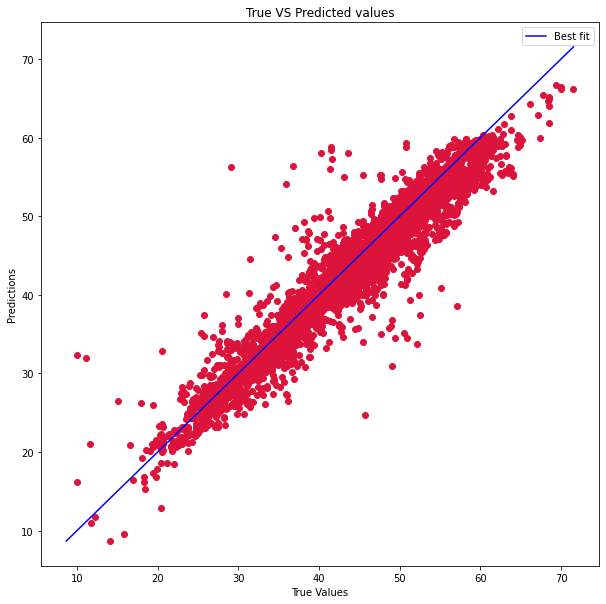

In [17]:
#plot graph of feature importances for better visualization
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_predicted, c='crimson')
plt.title('True VS Predicted values')

p1 = max(max(y_predicted), max(y_test))
p2 = min(min(y_predicted), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-', label='Best fit')
plt.xlabel('True Values')
plt.savefig("/content/drive/MyDrive/ML/Project 2/true_and_predicted" + 'Ca' + '.png', bbox_inches='tight', dpi=300)
plt.ylabel('Predictions')
plt.legend()
plt.show()

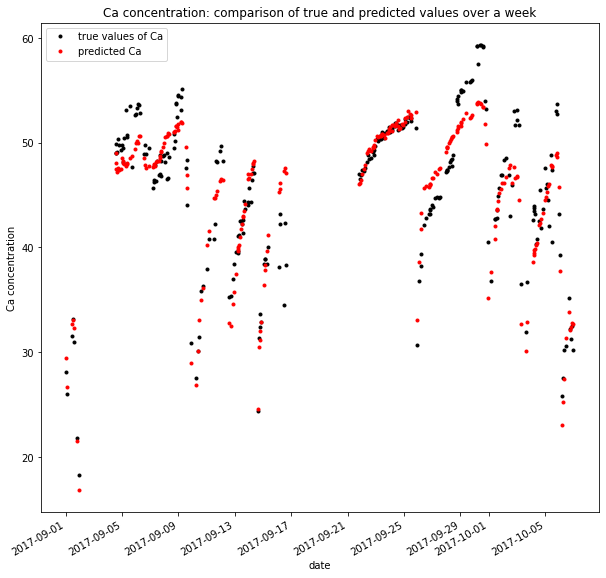

In [18]:
y_predicted = pd.DataFrame(y_predicted, columns=['predicted_Ca']).set_index(y_test_index)
y_true = pd.DataFrame(y_test, columns=['true_values']).set_index(y_test_index)

#dataframe with already available and predicted values
true_and_predicted = pd.concat([y_true, y_predicted])
#sort the datetime index
true_and_predicted = true_and_predicted.sort_index()
true_and_predicted.head()

start_date = "2017-09-01"
end_date = "2017-10-07"

plt.figure(figsize=(10,10))

true_and_predicted[start_date : end_date ]['true_values'].plot(style='k.', label='true values of Ca')
true_and_predicted[start_date : end_date ]['predicted_Ca'].plot(style='r.', label='predicted Ca')
plt.ylabel('Ca concentration')
plt.title('Ca concentration: comparison of true and predicted values over a week')
plt.legend()
plt.savefig("/content/drive/MyDrive/ML/Project 2/true_predicted_weekCa.png", bbox_inches='tight', dpi=300)
plt.show()

As we need to do the same steps as above for other ion concentrations, we create a single function in order to avoid copy pasting code.

In [31]:
def NN_train_and_test(ion_and_features, ion, ion_related_features,nb_epoch):
  y = ion_and_features[ion]
  X = ion_and_features[ion_related_features]

  #fill NaN values with the median of the respective column/feature
  X = X.fillna(X.median())  

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
  print('Length of the train dataset: {}'.format(len(X_train)))
  print('Length of the test dataset: {}'.format(len(X_test)))

  #save the dates of y_test
  y_test_index = y_test.index

  #transform to numpy
  X_train = X_train.to_numpy()
  X_test = X_test.to_numpy()
  y_train = y_train.to_numpy()
  y_test = y_test.to_numpy()


  # Train the neural network using the training sets
  model = fit_lstm(X_train, y_train,nb_epoch)

  # reshape input to be compatible with Keras LSTM Layer [TimeSteps,No_of_features,batch_size]
  X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
  # Make predictions on the testing set
  y_predicted = model.predict(X_test).flatten()

  #RMSE: 0 is perfect prediction
  print("The RMSE for the best model trained on all the training set, over the testing set, is: %.3f" 
        % mean_squared_error(y_test, y_predicted, squared=False))

  # The coefficient of determination: 1 is perfect prediction
  print("The coefficient of determination for the best model trained on all the training set, over the testing set, is: %.3f"
        % r2_score(y_test, y_predicted))

  print("The maximum error is: %.3f mg/l" % max_error(y_test, y_predicted))

  #Mean absolute error regression loss
  print("The mean absolute error is: %.3f mg/l" % mean_absolute_error(y_test, y_predicted))

  #Median absolute error regression loss
  print("The median absolute error is: %.3f mg/l" % median_absolute_error(y_test, y_predicted))

  plt.figure(figsize=(10,10))
  plt.scatter(y_test, y_predicted, c='crimson')
  plt.title('True VS Predicted values')
  p1 = max(max(y_predicted), max(y_test))
  p2 = min(min(y_predicted), min(y_test))
  plt.plot([p1, p2], [p1, p2], 'b-', label='Best fit')
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.savefig("/content/drive/MyDrive/ML/Project 2/true_and_predicted" + ion + '.png', bbox_inches='tight', dpi=300)
  plt.legend()
  plt.show()


  y_predicted = pd.DataFrame(y_predicted, columns=['predicted_'+ion]).set_index(y_test_index)
  y_true = pd.DataFrame(y_test, columns=['true_values']).set_index(y_test_index)

  #dataframe with already available and predicted values
  true_and_predicted = pd.concat([y_true, y_predicted])
  #sort the datetime index
  true_and_predicted = true_and_predicted.sort_index()
  true_and_predicted.head()

  start_date = "2017-09-01"
  end_date = "2017-09-02"

  plt.figure(figsize=(10,10))

  true_and_predicted[start_date : end_date ]['true_values'].plot(style='k.', label='true values of ' + ion)
  true_and_predicted[start_date : end_date ]['predicted_'+ion].plot(style='b.', label='predicted' + ion)
  plt.ylabel(ion + ' concentration')
  plt.title(ion + ' concentration: comparison of true and predicted values over a week')
  plt.legend()
  plt.savefig("/content/drive/MyDrive/ML/Project 2/true_predicted_week" + ion + '.png', bbox_inches='tight', dpi=300)
  plt.show()

  return model

### Predicting

In [20]:
features_for_prediction = pd.concat([probe_data10min[Ca_related_features], 
                                     calcium_and_features[Ca_related_features]]).drop_duplicates(keep=False)
#number of values to predict
features_for_prediction.shape   

(195885, 17)

In [21]:
#fill NaN values with the median of the respective column/feature
features_for_prediction = features_for_prediction.fillna(features_for_prediction.median())
#check that there aren't NaN values
np.count_nonzero(np.isnan(features_for_prediction))

0

In [22]:
X_prediction = features_for_prediction.to_numpy()
# reshape input to be compatible with Keras LSTM Layer [TimeSteps,No_of_features,batch_size]
X_prediction = X_prediction.reshape(X_prediction.shape[0],X_prediction.shape[1],1)
y_predicted = ca_lstm_model.predict(X_prediction)
y_predicted = pd.DataFrame(y_predicted, columns=['predicted_Ca']).set_index(features_for_prediction.index)
y_predicted.head()

,predicted_Ca
date,
2016-08-30 00:00:00,51.433533
2016-08-30 00:10:00,51.538128
2016-08-30 00:20:00,51.621075
2016-08-30 00:30:00,51.613800
2016-08-30 00:40:00,51.639534


In [23]:
y_available = calcium_and_features['Ca'].to_frame(name='available_Ca')
y_available.head()

,available_Ca
date,
2017-03-06 17:20:00,64.711
2017-03-06 18:20:00,64.043
2017-03-06 21:20:00,63.400
2017-03-06 22:20:00,63.785
2017-03-06 23:20:00,63.603


In [24]:
#dataframe with already available and predicted values
available_and_predicted = pd.concat([y_available, y_predicted])
#sort the datetime index
available_and_predicted = available_and_predicted.sort_index()
available_and_predicted.head()

,available_Ca,predicted_Ca
date,,
2016-08-30 00:00:00,NaN,51.433533
2016-08-30 00:10:00,NaN,51.538128
2016-08-30 00:20:00,NaN,51.621075
2016-08-30 00:30:00,NaN,51.613800
2016-08-30 00:40:00,NaN,51.639534


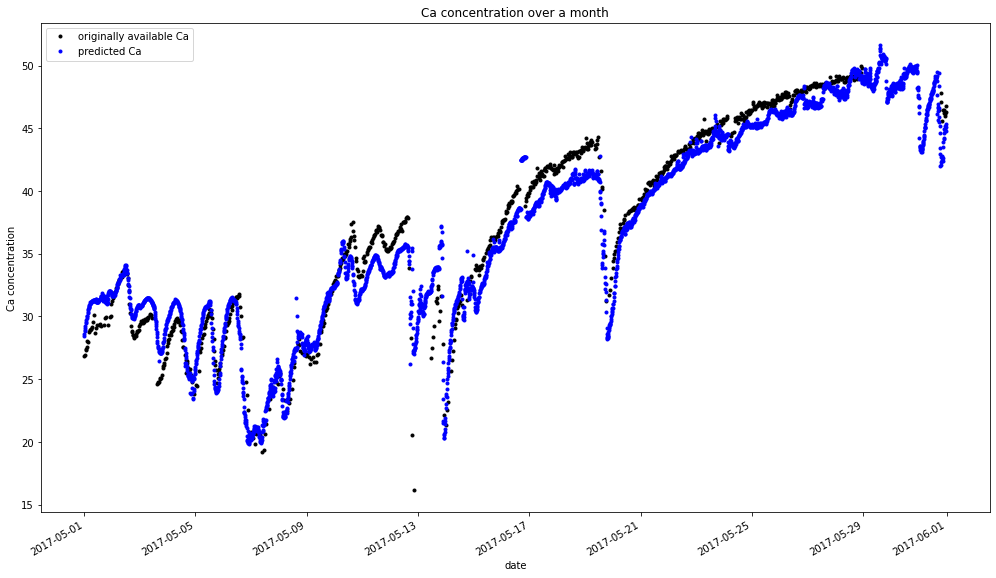

In [25]:
start_date = "2017-05"

plt.figure(figsize=(17,10))

available_and_predicted[start_date]['available_Ca'].plot(style='k.', label='originally available Ca')
available_and_predicted[start_date]['predicted_Ca'].plot(style='b.', label='predicted Ca')
plt.ylabel('Ca concentration')
plt.title('Ca concentration over a month')
plt.legend()
plt.show()

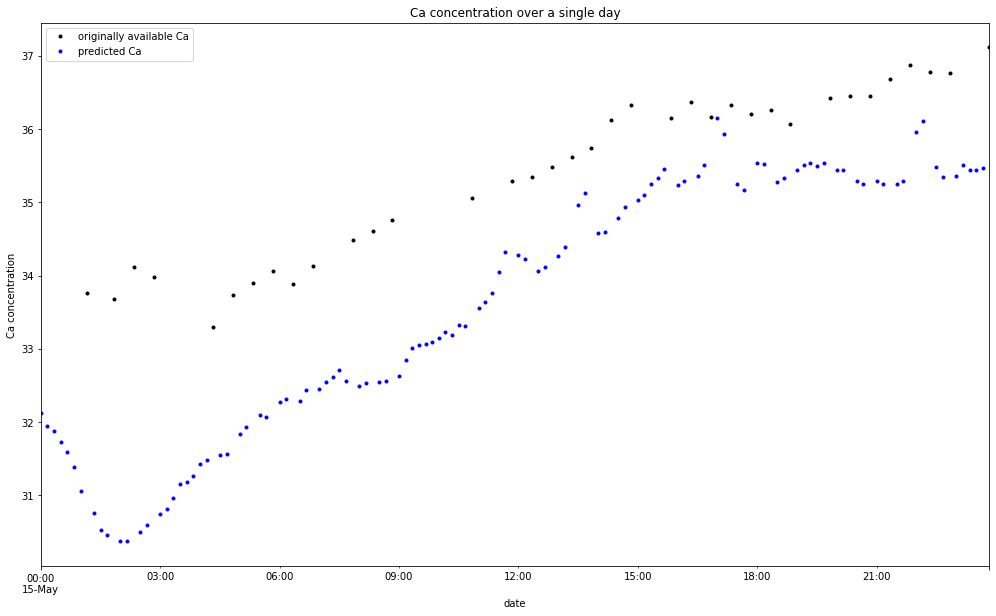

In [26]:
start_date = "2017-05-15"

plt.figure(figsize=(17,10))

available_and_predicted[start_date]['available_Ca'].plot(style='k.', label='originally available Ca')
available_and_predicted[start_date]['predicted_Ca'].plot(style='b.', label='predicted Ca')
plt.ylabel('Ca concentration')
plt.title('Ca concentration over a single day')
plt.legend()
plt.show()

For the prediction, we also create a function that we will be able to use for the other ion concentrations.

In [27]:
def NNpredict(ion, model, ion_related_features, ion_and_features, time_span_1, time_span_2):
  
  features_for_prediction = pd.concat([probe_data10min[ion_related_features], 
                                     ion_and_features[ion_related_features]]).drop_duplicates(keep=False)
                      
  #fill NaN values with the median of the respective column/feature
  features_for_prediction = features_for_prediction.fillna(features_for_prediction.median())

  X_prediction = features_for_prediction.to_numpy()
  # reshape input to be compatible with Keras LSTM Layer [TimeSteps,No_of_features,batch_size]
  X_prediction = X_prediction.reshape(X_prediction.shape[0],X_prediction.shape[1],1)
  y_predicted = model.predict(X_prediction)

  y_predicted = y_predicted.flatten()

  y_predicted = pd.DataFrame(y_predicted, columns=['predicted_' + ion]).set_index(features_for_prediction.index)
  y_available = ion_and_features[ion].to_frame(name='available_' + ion)

  #dataframe with already available and predicted values
  available_and_predicted = pd.concat([y_available, y_predicted])
  #sort the datetime index
  available_and_predicted = available_and_predicted.sort_index()

  #Plot over a month
  plt.figure(figsize=(17,10))
  available_and_predicted[time_span_1]['available_' + ion].plot(style='k.', label='originally available ' + ion)
  available_and_predicted[time_span_1]['predicted_' + ion].plot(style='b.', label='predicted ' + ion)
  plt.ylabel(ion + ' concentration')
  plt.title(ion + ' concentration over a month')
  plt.legend()
  plt.show()

  #Zoom in/ plot over a day
  plt.figure(figsize=(17,10))
  available_and_predicted[time_span_2]['available_' + ion].plot(style='k.', label='originally available ' + ion)
  available_and_predicted[time_span_2]['predicted_' + ion].plot(style='b.', label='predicted ' + ion)
  plt.ylabel(ion + ' concentration')
  plt.title(ion + ' concentration over a single day')
  plt.legend()
  plt.show()

## Sulfate


In [28]:
sulfate = ion_concentration[ion_concentration['SO4'].notna()].SO4.to_frame()
sulfate_and_features = pd.merge(probe_data10min_no_comments, sulfate, left_index=True, right_index=True)
sulfate_and_features.head(2)

,precipitation,water_temperature,water_electrical_conductivity,flow,turbidity,NO3-Neq,TOCeq,DOCeq,dissolved_oxygen,temperature_DO,conductivity,temperature_EC,pH,ORP,dQ/dt,time_of_day,time_of_year,SO4
date,,,,,,,,,,,,,,,,,,
2017-03-06 17:20:00,0.0,0.204120,208.0,2.512760,0.955688,1.11,0.797268,3.61,9.71,5.1,210.0,4.2,8.03,371.0,-0.000771,-0.984808,0.901735,17.637
2017-03-06 18:20:00,0.0,0.255273,206.5,2.503481,1.024896,1.10,0.808211,3.90,9.84,5.5,208.0,4.5,8.00,375.0,0.000000,-0.996195,0.902045,17.740


In [29]:
sulfate_related_features = sulfate_and_features.columns[0:len(sulfate_and_features.columns)-1]
sulfate_related_features

Index(['precipitation', 'water_temperature', 'water_electrical_conductivity',
       'flow', 'turbidity', 'NO3-Neq', 'TOCeq', 'DOCeq', 'dissolved_oxygen',
       'temperature_DO', 'conductivity', 'temperature_EC', 'pH', 'ORP',
       'dQ/dt', 'time_of_day', 'time_of_year'],
      dtype='object')

### Model training and testing

Length of the train dataset: 9965
Length of the test dataset: 4271
The RMSE for the best model trained on all the training set, over the testing set, is: 1.338
The coefficient of determination for the best model trained on all the training set, over the testing set, is: 0.941
The maximum error is: 10.974 mg/l
The mean absolute error is: 0.887 mg/l
The median absolute error is: 0.616 mg/l


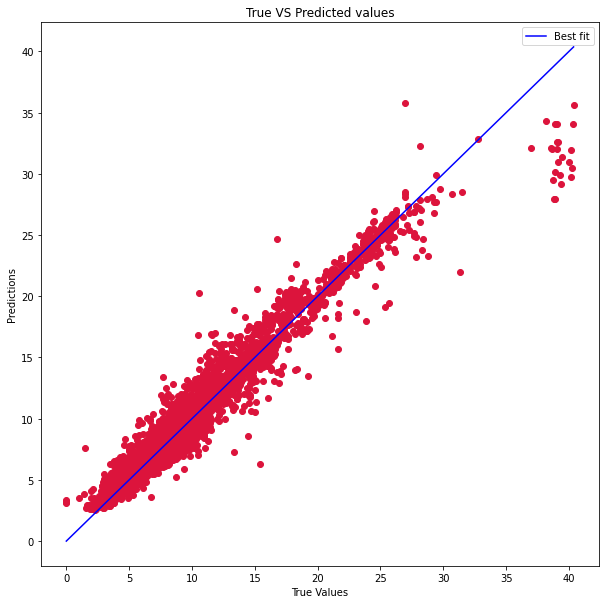

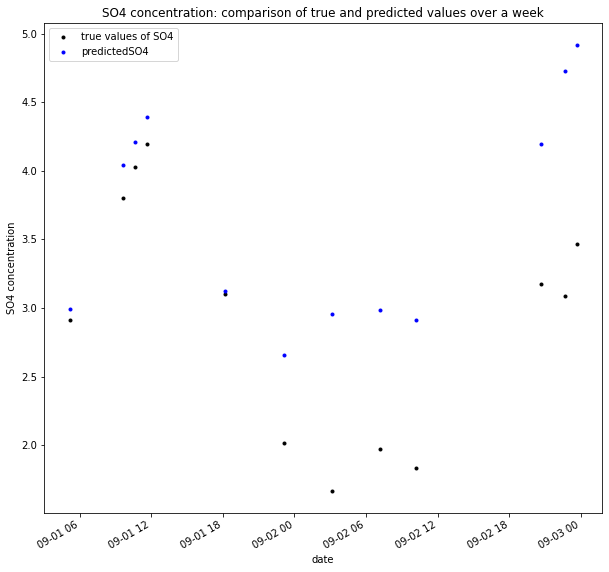

In [32]:
so_lstm_model = NN_train_and_test(sulfate_and_features, 'SO4', sulfate_related_features,nb_epoch=50)#more epoch might be better but long run

### Predicting

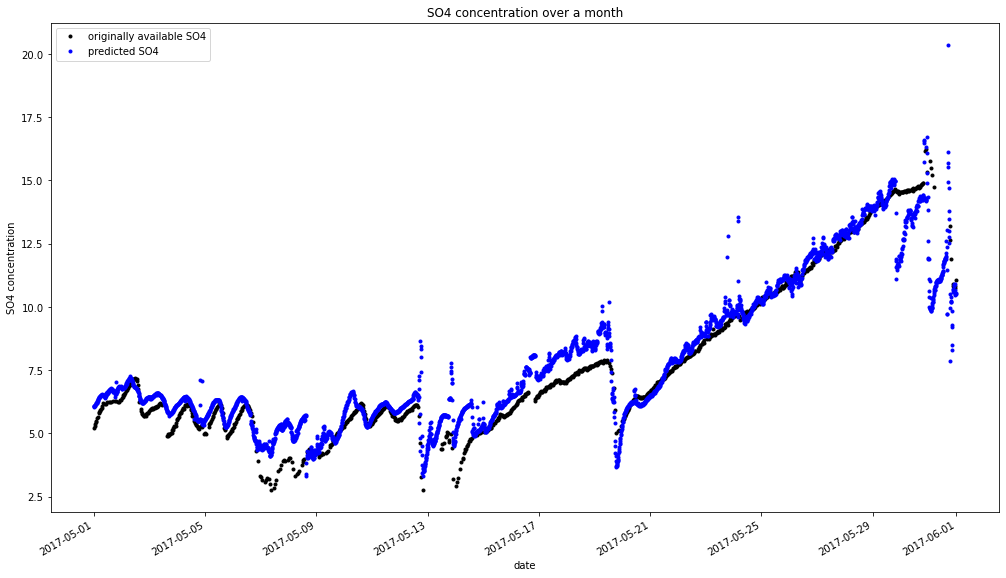

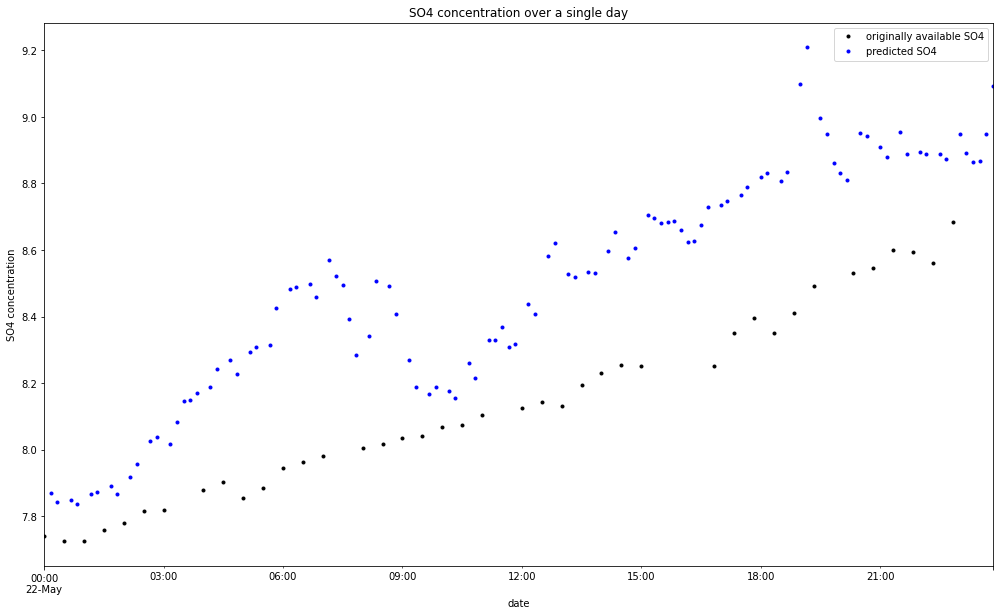

In [33]:
NNpredict('SO4', so_lstm_model, sulfate_related_features, sulfate_and_features, '2017-05', '2017-05-22')

## Nitrate

In [34]:
nitrate = ion_concentration[ion_concentration['NO3'].notna()].NO3.to_frame()
nitrate_and_features = pd.merge(probe_data10min_no_comments, nitrate, left_index=True, right_index=True)
nitrate_and_features.head(2)

,precipitation,water_temperature,water_electrical_conductivity,flow,turbidity,NO3-Neq,TOCeq,DOCeq,dissolved_oxygen,temperature_DO,conductivity,temperature_EC,pH,ORP,dQ/dt,time_of_day,time_of_year,NO3
date,,,,,,,,,,,,,,,,,,
2017-03-06 17:20:00,0.0,0.204120,208.0,2.512760,0.955688,1.11,0.797268,3.61,9.71,5.1,210.0,4.2,8.03,371.0,-0.000771,-0.984808,0.901735,1.751
2017-03-06 18:20:00,0.0,0.255273,206.5,2.503481,1.024896,1.10,0.808211,3.90,9.84,5.5,208.0,4.5,8.00,375.0,0.000000,-0.996195,0.902045,1.771


In [35]:
nitrate_related_features = nitrate_and_features.columns[0:len(nitrate_and_features.columns)-1]
nitrate_related_features

Index(['precipitation', 'water_temperature', 'water_electrical_conductivity',
       'flow', 'turbidity', 'NO3-Neq', 'TOCeq', 'DOCeq', 'dissolved_oxygen',
       'temperature_DO', 'conductivity', 'temperature_EC', 'pH', 'ORP',
       'dQ/dt', 'time_of_day', 'time_of_year'],
      dtype='object')

### Model training and testing

Length of the train dataset: 8855
Length of the test dataset: 3795
The RMSE for the best model trained on all the training set, over the testing set, is: 0.200
The coefficient of determination for the best model trained on all the training set, over the testing set, is: 0.777
The maximum error is: 1.572 mg/l
The mean absolute error is: 0.137 mg/l
The median absolute error is: 0.097 mg/l


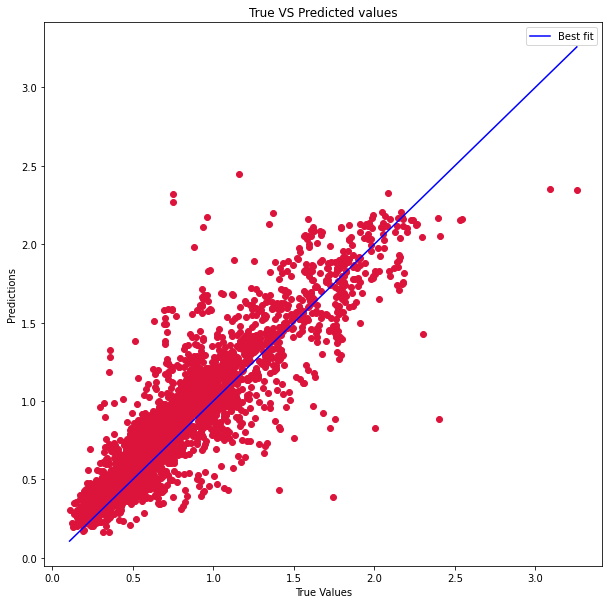

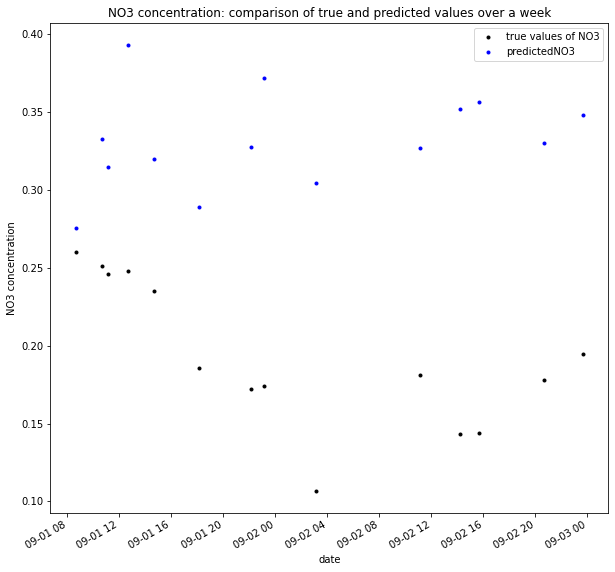

In [36]:
no3_lstm_model = NN_train_and_test(nitrate_and_features, 'NO3', nitrate_related_features,nb_epoch=50)#more epochs might be better but long run

### Predicting

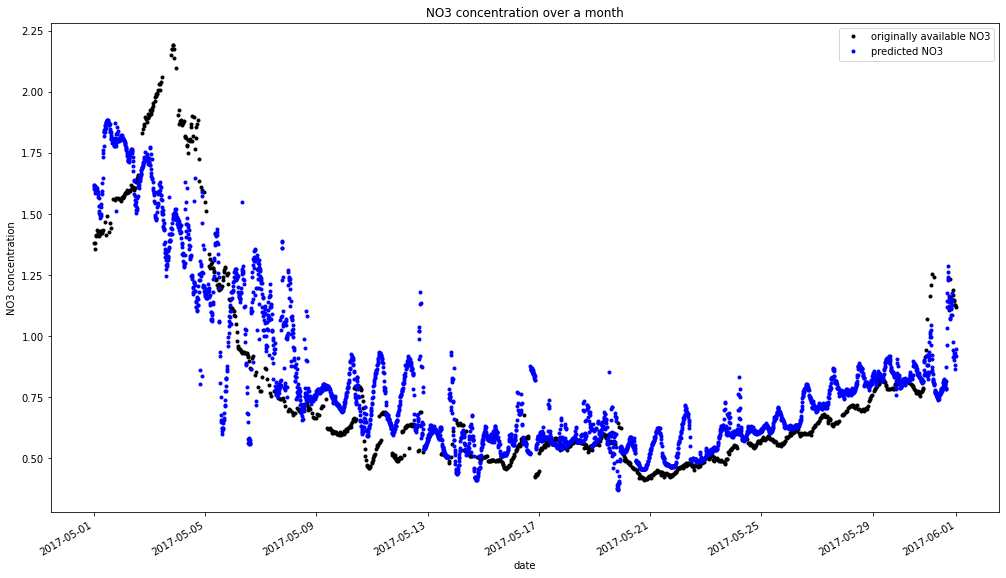

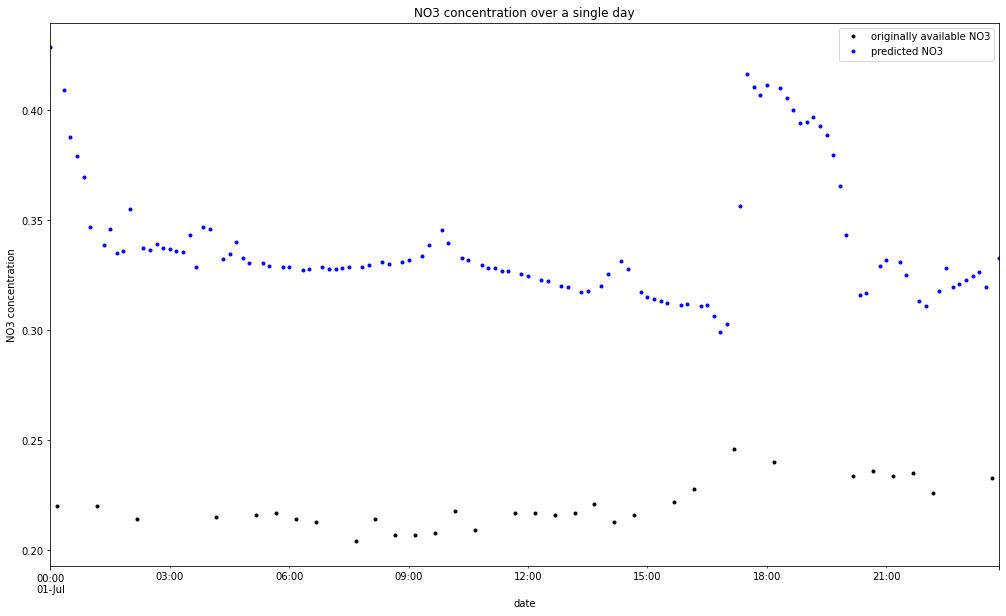

In [37]:
NNpredict('NO3', no3_lstm_model, nitrate_related_features, nitrate_and_features, '2017-05', '2017-07-01')

## Other ions

### Potassium

In [38]:
potassium = ion_concentration[ion_concentration['K'].notna()].K.to_frame()
potassium_and_features = pd.merge(probe_data10min_no_comments, potassium, left_index=True, right_index=True)
potassium_and_features.head(2)

,precipitation,water_temperature,water_electrical_conductivity,flow,turbidity,NO3-Neq,TOCeq,DOCeq,dissolved_oxygen,temperature_DO,conductivity,temperature_EC,pH,ORP,dQ/dt,time_of_day,time_of_year,K
date,,,,,,,,,,,,,,,,,,
2017-03-06 18:20:00,0.0,0.255273,206.5,2.503481,1.024896,1.10,0.808211,3.90,9.84,5.5,208.0,4.5,8.00,375.0,0.000000,-0.996195,0.902045,1.112
2017-03-06 21:20:00,0.3,0.204120,205.0,2.406901,0.855519,1.17,0.813581,3.92,9.99,5.4,207.0,4.4,8.02,381.0,-0.001714,-0.642788,0.902971,1.101


In [39]:
potassium_related_features = potassium_and_features.columns[0:len(potassium_and_features.columns)-1]
potassium_related_features

Index(['precipitation', 'water_temperature', 'water_electrical_conductivity',
       'flow', 'turbidity', 'NO3-Neq', 'TOCeq', 'DOCeq', 'dissolved_oxygen',
       'temperature_DO', 'conductivity', 'temperature_EC', 'pH', 'ORP',
       'dQ/dt', 'time_of_day', 'time_of_year'],
      dtype='object')

#### Model training and testing

Length of the train dataset: 9655
Length of the test dataset: 4138
The RMSE for the best model trained on all the training set, over the testing set, is: 0.066
The coefficient of determination for the best model trained on all the training set, over the testing set, is: 0.861
The maximum error is: 0.574 mg/l
The mean absolute error is: 0.045 mg/l
The median absolute error is: 0.032 mg/l


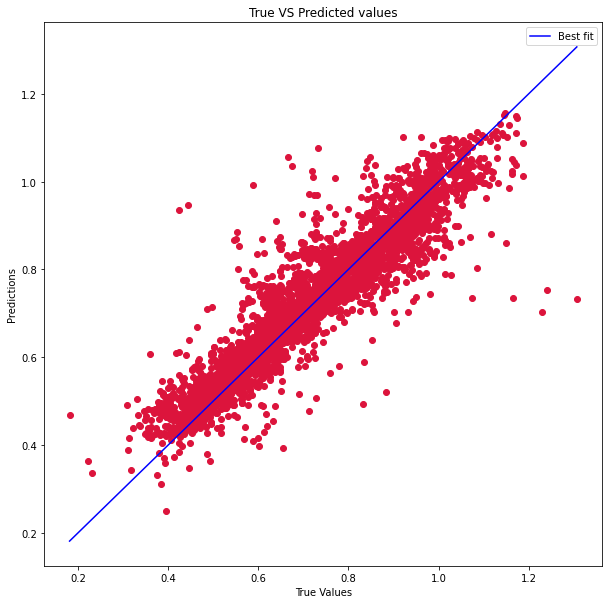

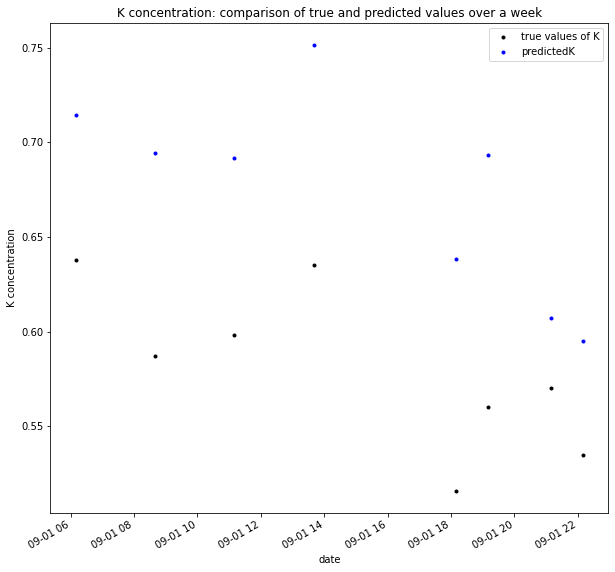

In [40]:
k_lstm_model = NN_train_and_test(potassium_and_features, 'K', potassium_related_features,nb_epoch=50) #more epoch might be better but long run

#### Predicting

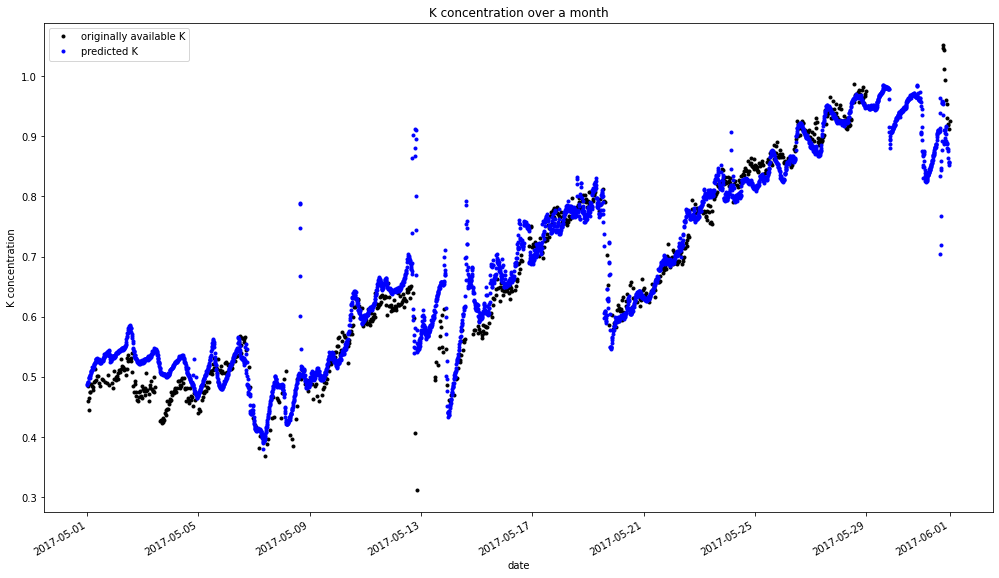

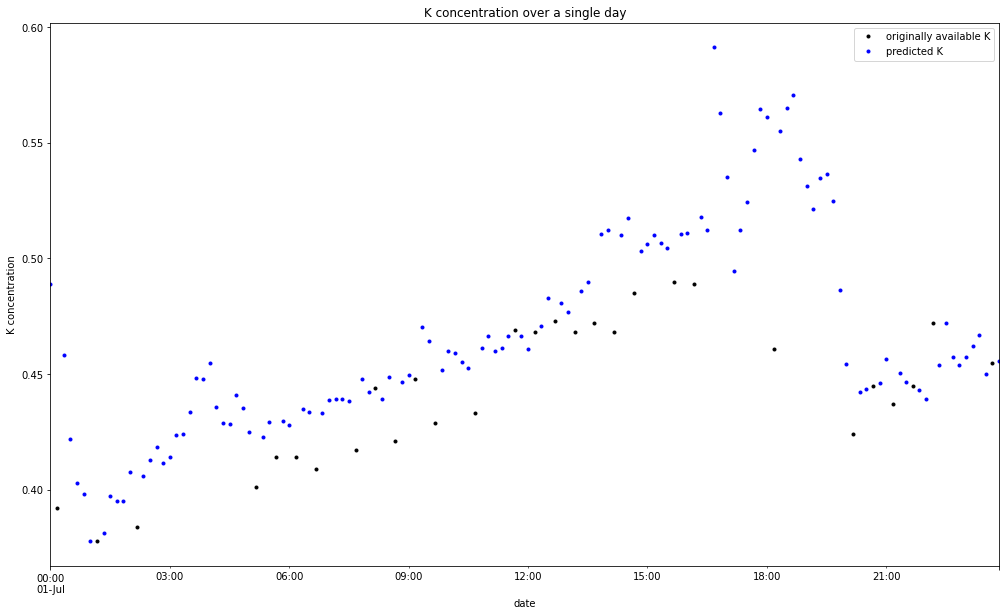

In [41]:
NNpredict('K', k_lstm_model, potassium_related_features, potassium_and_features, '2017-05', '2017-07-01')

### Magnesium

In [42]:
magnesium = ion_concentration[ion_concentration['Mg'].notna()].Mg.to_frame()
magnesium_and_features = pd.merge(probe_data10min_no_comments, magnesium, left_index=True, right_index=True)
magnesium_and_features.head(2)

,precipitation,water_temperature,water_electrical_conductivity,flow,turbidity,NO3-Neq,TOCeq,DOCeq,dissolved_oxygen,temperature_DO,conductivity,temperature_EC,pH,ORP,dQ/dt,time_of_day,time_of_year,Mg
date,,,,,,,,,,,,,,,,,,
2017-03-06 17:20:00,0.0,0.204120,208.0,2.512760,0.955688,1.11,0.797268,3.61,9.71,5.1,210.0,4.2,8.03,371.0,-0.000771,-0.984808,0.901735,4.209
2017-03-06 18:20:00,0.0,0.255273,206.5,2.503481,1.024896,1.10,0.808211,3.90,9.84,5.5,208.0,4.5,8.00,375.0,0.000000,-0.996195,0.902045,4.241


In [43]:
magnesium_related_features = magnesium_and_features.columns[0:len(magnesium_and_features.columns)-1]
magnesium_related_features

Index(['precipitation', 'water_temperature', 'water_electrical_conductivity',
       'flow', 'turbidity', 'NO3-Neq', 'TOCeq', 'DOCeq', 'dissolved_oxygen',
       'temperature_DO', 'conductivity', 'temperature_EC', 'pH', 'ORP',
       'dQ/dt', 'time_of_day', 'time_of_year'],
      dtype='object')

#### Model training and testing

In [ ]:
mg_lstm_model = NN_train_and_test(magnesium_and_features, 'Mg', magnesium_related_features,nb_epoch=50) #more epoch might be better but long run

Length of the train dataset: 9040
Length of the test dataset: 3875


#### Predicting 

In [ ]:
NNpredict('Mg', mg_lstm_model, magnesium_related_features, magnesium_and_features, '2017-05', '2017-07-01')

### Sodium

In [ ]:
sodium = ion_concentration[ion_concentration['Na'].notna()].Na.to_frame()
sodium_and_features = pd.merge(probe_data10min_no_comments, sodium, left_index=True, right_index=True)
sodium_and_features.head(2)

In [ ]:
sodium_related_features = sodium_and_features.columns[0:len(potassium_and_features.columns)-1]
sodium_related_features

#### Model training and testing

In [ ]:
na_lstm_model = NN_train_and_test(sodium_and_features, 'Na', sodium_related_features,nb_epoch=50) #more epoch might be better but long run

#### Predicting

In [ ]:
NNpredict('Na', na_lstm_model, sodium_related_features, sodium_and_features, '2017-05', '2017-07-01')

### Chloride

In [ ]:
chloride = ion_concentration[ion_concentration['Cl'].notna()].Cl.to_frame()
chloride_and_features = pd.merge(probe_data10min_no_comments, chloride, left_index=True, right_index=True)
chloride_and_features.head(2)

In [ ]:
chloride_related_features = chloride_and_features.columns[0:len(chloride_and_features.columns)-1]
chloride_related_features

#### Model training and testing

In [ ]:
cl_lstm_model = NN_train_and_test(chloride_and_features, 'Cl', chloride_related_features,nb_epoch=50) #more epoch might be better but long run

#### Predicting 

In [ ]:
NNpredict('Cl', cl_lstm_model, chloride_related_features, chloride_and_features, '2017-05', '2017-07-01')